# The Autoregressive Model (AR)

The AR model is a linear model that uses the sum of previous values multiplied by a numeric factor to estimate the current value. When only using 1 lagged value, it is written as:
$$
x_t = C + \varphi x_{t-1} + \epsilon_t
$$

where

* $x_{t-1}$: The values of $x$ during the previous period
* $\varphi$: The numeric constant by which we multiply the lagged variable 
  * = the part of the previous value which remains in the future 
  * $-1 < \varphi < 1$
  * if $|\varphi| > 1$, the value grows exponentially 
* $\epsilon_t$: Residual. The difference between our prediction for period t and the correct value  

When using 2 lags, it is 
$$
x_t = C + \varphi_1 x_{t-1} + \varphi_2 x_{t-2} + \epsilon_t
$$

and this means the value one lag and two lags prior affect the current value, being multiplied by $\varphi_1$ and $\varphi_2$ respectively.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima_model import ARMA
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

# Original data

In [2]:
raw_data = pd.read_csv("../data/Index2018.csv")
df_comp = raw_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value'] = df_comp.ftse
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']

size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

# The ACF

First, check how many previous values to include. We can perform the ACF first.

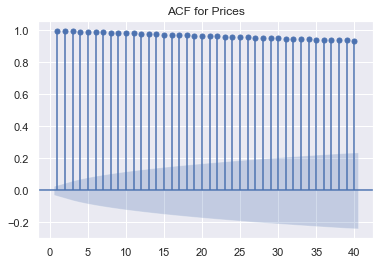

In [4]:
sgt.plot_acf(df.market_value, zero=False, lags=40)
plt.title('ACF for Prices')
plt.show()

It seems all of the 40 lags are correlated with the current value. However, we wouldn't want to include all of them because of the risk of overfitting. Also, each lag has culmulate effect, which is redundant. Therefore, We would want to perform the PACF so that we can reduce the number of variables as well as use the most relevant individual lags.

# The PACF

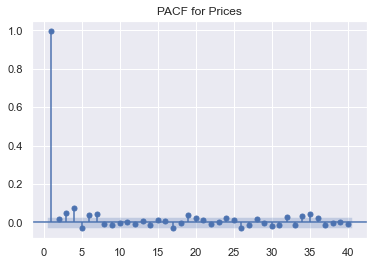

In [5]:
sgt.plot_pacf(df.market_value, zero=False, lags=40, method=('ols'))
plt.title('PACF for Prices')
plt.show()

The lags more than 25 are not significant, so the coefficients will be extremely close to 0. Their impact on the model is minimal, so they're not relevant to us. Also, lags more than 22, which is 22 business days, is longer than a month ago. They would not affect the current price that much. 

# The AR(1) Model

$$x_t = C + \varphi x_{t-1} + \epsilon_t$$# The AR(1) Model

In [6]:
# (1, 0) = number of past values, not taking any of the residual values into consideration
model_ar = ARMA(df.market_value, order=(1,0))  
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 0)   Log Likelihood              -27622.598
Method:                       css-mle   S.D. of innovations             59.258
Date:                Sun, 17 Jan 2021   AIC                          55251.196
Time:                        23:49:41   BIC                          55270.760
Sample:                    01-07-1994   HQIC                         55258.052
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5055.8541    485.798     10.407      0.000    4103.707    6008.001
ar.L1.market_value     0.9985      0.001   1298.620      0.000       0.997       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
-----------------------------------------------------------------------------
"""

* coef: numeric value associated with C and $\varphi$
* std err: a measure of how far on average the model's predictions are from the true values
* z: associated statistics for significance with the P values
* P-value: p-value associated with C and $\varphi$. As both P-values are zeroes, both C and $\varphi$ are significantly different from 0.
* [0.025, 0.975]: Critical values for the 95% confidence interval

## Higher-Lag AR Models

In [7]:
# AR(2)
model_ar_2 = ARMA(df.market_value, order=(2,0))  
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(2, 0)   Log Likelihood              -27621.871
Method:                       css-mle   S.D. of innovations             59.249
Date:                Sun, 17 Jan 2021   AIC                          55251.742
Time:                        23:49:42   BIC                          55277.827
Sample:                    01-07-1994   HQIC                         55260.883
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6412    495.717     10.267      0.000    4118.054    6061.228
ar.L1.market_value     0.9814      0.014     69.595      0.000       0.954       1.009
ar.L2.market_value     0.0171      0.014      1.211      0.226      -0.011       0.045
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
AR.2          -58.4633           +0.0000j           58.4633            0.5000
-----------------------------------------------------------------------------
"""

The p value of the second lag is greater than 0.05, so we can't reject the null hypothesis that the coefficient is zero. This can be also interpreted as the effect of the second lag is already captured in the first lag. Thus, adding another lag does not improve the model significantly.

We should check more complex models such as AR(3) or AR(4). However, the more lags we include, the more likely the model will overfit. Therefore, we want to perform the Log-Likelihood Test.

In [8]:
# AR(3)
model_ar_3 = ARMA(df.market_value, order=(3,0))  
results_ar_3 = model_ar_3.fit()
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(3, 0)   Log Likelihood              -27615.871
Method:                       css-mle   S.D. of innovations             59.178
Date:                Sun, 17 Jan 2021   AIC                          55241.742
Time:                        23:49:42   BIC                          55274.349
Sample:                    01-07-1994   HQIC                         55253.168
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6411    520.379      9.781      0.000    4069.718    6109.565
ar.L1.market_value     0.9806      0.014     69.619      0.000       0.953       1.008
ar.L2.market_value    -0.0309      0.020     -1.563      0.118      -0.070       0.008
ar.L3.market_value     0.0489      0.014      3.466      0.001       0.021       0.077
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0013           -0.0000j            1.0013           -0.0000
AR.2           -0.1850           -4.5161j            4.5199           -0.2565
AR.3           -0.1850           +4.5161j            4.5199            0.2565
-----------------------------------------------------------------------------
"""

Comparing the AR(2) and AR(3);  
- The log likelihood increased (-27621.871 -> -27615.871)  
- The AIC decreased (55251.742 -> 55241.742)  
- The BIC decreased (55277.827 -> 55274.349)  
- The HQIC decreased (55260.883 -> 55253.168)


In general, we want higher log likelihood but lower information criterion (AIC, BIC, HQIC). When it is the case, we want to perform Log Likelihood Test to test if the two models are significantly different. 

# LLR Test (Log Likelihood Test)

In [9]:
def LLR_test(mod_1, mod_2, DF=1):
    # DF: degrees of freedom
    
    # log likelihood
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    
    # test statistic
    LR = (2 * (L2 - L1))
    p = chi2.sf(LR, DF).round(3)
    
    return p

# Comparing Higher-Lag AR Models 

In [10]:
LLR_test(model_ar_2, model_ar_3)

0.001

The p-value is lower than 0.05, meaning it is statistically significant that the two models are different, thus we need to use the second model which has a higher log likelihood and lower information criterion.

In [11]:
# AR(4)
model_ar_4 = ARMA(df.market_value, order=(4,0))  
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary())
print("LLR Test:")
print(LLR_test(model_ar_3, model_ar_4))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(4, 0)   Log Likelihood              -27602.565
Method:                       css-mle   S.D. of innovations             59.022
Date:                Sun, 17 Jan 2021   AIC                          55217.130
Time:                        23:49:43   BIC                          55256.258
Sample:                    01-07-1994   HQIC                         55230.841
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6416    559.979      9.089      0.000    3992.102    6187.181
ar.L1.market_value     0.9770      0.014     69.492      0.000       0.949       1.005
ar.L2.market_value  

Conditions to meet to stop increasing the model complexity: 
- Non-significant p-value for the LLR test   
- Non-significant p-value for the highest lag coefficient   

In [12]:
# AR(5)
model_ar_5 = ARMA(df.market_value, order=(5,0))  
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())
print("LLR Test:")
print(LLR_test(model_ar_4, model_ar_5))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(5, 0)   Log Likelihood              -27600.348
Method:                       css-mle   S.D. of innovations             58.996
Date:                Sun, 17 Jan 2021   AIC                          55214.697
Time:                        23:49:45   BIC                          55260.346
Sample:                    01-07-1994   HQIC                         55230.693
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6413    543.575      9.363      0.000    4024.254    6155.029
ar.L1.market_value     0.9791      0.014     69.481      0.000       0.952       1.007
ar.L2.market_value  

In [13]:
# AR(6)
model_ar_6 = ARMA(df.market_value, order=(6,0))  
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())
print("LLR Test:")
print(LLR_test(model_ar_5, model_ar_6))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 0)   Log Likelihood              -27596.474
Method:                       css-mle   S.D. of innovations             58.950
Date:                Sun, 17 Jan 2021   AIC                          55208.947
Time:                        23:49:47   BIC                          55261.118
Sample:                    01-07-1994   HQIC                         55227.229
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6418    565.260      9.004      0.000    3981.752    6197.532
ar.L1.market_value     0.9803      0.014     69.604      0.000       0.953       1.008
ar.L2.market_value  

In [14]:
# AR(7)
model_ar_7 = ARMA(df.market_value, order=(7,0))  
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print("LLR Test:")
print(LLR_test(model_ar_6, model_ar_7))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(7, 0)   Log Likelihood              -27591.900
Method:                       css-mle   S.D. of innovations             58.896
Date:                Sun, 17 Jan 2021   AIC                          55201.799
Time:                        23:49:51   BIC                          55260.492
Sample:                    01-07-1994   HQIC                         55222.366
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6412    589.588      8.633      0.000    3934.070    6245.213
ar.L1.market_value     0.9786      0.014     69.518      0.000       0.951       1.006
ar.L2.market_value  

In [15]:
# AR(8)
model_ar_8 = ARMA(df.market_value, order=(8,0))  
results_ar_8 = model_ar_8.fit()
print(results_ar_8.summary())
print("LLR Test:")
print(LLR_test(model_ar_7, model_ar_8))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(8, 0)   Log Likelihood              -27591.739
Method:                       css-mle   S.D. of innovations             58.894
Date:                Sun, 17 Jan 2021   AIC                          55203.478
Time:                        23:49:55   BIC                          55268.692
Sample:                    01-07-1994   HQIC                         55226.329
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6415    584.991      8.700      0.000    3943.081    6236.202
ar.L1.market_value     0.9790      0.014     69.476      0.000       0.951       1.007
ar.L2.market_value  

Including the 8th lag does not improve our model. We should stop at AR(7).

Also, compare AR(1) vs AR(7) to test if AR(7) is significantly better than AR(1). And the below test shows it is.

In [16]:
print(LLR_test(model_ar, model_ar_7, DF=6))

0.0
